<a href="https://colab.research.google.com/github/hahaslav/isGameModel/blob/main/transformer_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!uv pip install transformers datasets accelerate torch torchvision scikit-learn

Using Python 3.12.12 environment at: /usr
Audited 6 packages in 422ms


In [ ]:
from google.colab import drive
from datasets import load_dataset
from transformers import ViTImageProcessor

# 1. Mount Google Drive
drive.mount('/content/drive')

# REPLACE THIS with the path to the folder containing 'work' and 'game' folders
dataset_path = "/content/drive/MyDrive/isGameImages/"

# 2. Load the dataset
# This function automatically looks for subfolders and treats them as labels
print("Loading images...")
ds = load_dataset("imagefolder", data_dir=dataset_path)

# 3. Split the dataset (0.7 Train, 0.3 Test)
# The load_dataset function usually creates a single 'train' split by default
split_ds = ds['train'].train_test_split(test_size=0.3, seed=42)

print(f"Training samples: {len(split_ds['train'])}")
print(f"Testing samples: {len(split_ds['test'])}")

# Check the label mapping (e.g., {'game': 0, 'work': 1})
labels = split_ds['train'].features['label'].names
label2id = {label: str(i) for i, label in enumerate(labels)}
id2label = {str(i): label for i, label in enumerate(labels)}
print(f"Labels: {labels}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading images...


Resolving data files:   0%|          | 0/474 [00:00<?, ?it/s]

Training samples: 331
Testing samples: 143
Labels: ['game', 'work']


In [ ]:
from torchvision.transforms import (
    Compose, Normalize, RandomRotation, RandomResizedCrop,
    Resize, ToTensor, CenterCrop
)

# Load the processor for the specific model we will use
model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)

# Define normalization based on the pre-trained model's requirements
normalize = Normalize(mean=processor.image_mean, std=processor.image_std)

# Define transforms
# We use data augmentation for training to prevent overfitting on small datasets
train_transforms = Compose([
    Resize((224, 224)), # Resize your 960x540 images to 224x224
    RandomRotation(15), # Slight rotation to help model generalize
    ToTensor(),
    normalize,
])

val_transforms = Compose([
    Resize((224, 224)),
    ToTensor(),
    normalize,
])

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [
        val_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

# Apply transforms to the dataset
split_ds['train'].set_transform(preprocess_train)
split_ds['test'].set_transform(preprocess_val)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
from transformers import ViTForImageClassification, TrainingArguments, Trainer
import torch
import numpy as np
from sklearn.metrics import accuracy_score

# --- STEP 1: Pre-process everything upfront ---
# We stop using set_transform (on-the-fly) and use map (pre-compute).
# This avoids the conflict between the Trainer and the image column.

def process_train(examples):
    # Apply the training transforms (Rotation, Resize, etc.)
    examples['pixel_values'] = [train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def process_val(examples):
    # Apply the validation transforms (Just Resize)
    examples['pixel_values'] = [val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

print("Processing training set...")
train_dataset = split_ds['train'].map(
    process_train,
    batched=True,
    remove_columns=['image', 'label'] # Delete original 'image' and 'label' immediately
)

print("Processing testing set...")
test_dataset = split_ds['test'].map(
    process_val,
    batched=True,
    remove_columns=['image', 'label']
)

# Rename 'label' comes from the dataset, but we need 'labels' for the model.
# Since we removed 'label' above, we need to ensure we kept it as 'labels'
# Let's fix the mapping to be safer:

def format_labels(examples):
    return {"labels": examples["label"]}

# Re-run map to ensure labels are correct (safest way given previous renames)
# We map from the ORIGINAL split_ds again to be safe.
train_dataset = split_ds['train'].map(
    lambda x: {"pixel_values": [train_transforms(img.convert("RGB")) for img in x['image']], "labels": x['label']},
    batched=True,
    remove_columns=['image', 'label']
)
test_dataset = split_ds['test'].map(
    lambda x: {"pixel_values": [val_transforms(img.convert("RGB")) for img in x['image']], "labels": x['label']},
    batched=True,
    remove_columns=['image', 'label']
)

# Set the format to PyTorch tensors explicitly
train_dataset.set_format("torch")
test_dataset.set_format("torch")

print("Preprocessing done. Dataset contains only tensors now.")

# --- STEP 2: Configure Model & Trainer ---

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(labels, predictions))

model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir="./vit-work-vs-game",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-4,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_dir='./logs',
    report_to="none",            # No wandb
    remove_unused_columns=False, # Safe to be False now, because we manually cleaned the dataset
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset, # Use the pre-processed dataset
    eval_dataset=test_dataset,   # Use the pre-processed dataset
    compute_metrics=compute_metrics,
    # processing_class is not strictly needed here because we already processed the data,
    # but we leave it for consistency.
    processing_class=processor,
)

# --- STEP 3: Train ---
trainer.train()

Processing training set...


Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Processing testing set...


Map:   0%|          | 0/143 [00:00<?, ? examples/s]

Map:   0%|          | 0/331 [00:00<?, ? examples/s]

Map:   0%|          | 0/143 [00:00<?, ? examples/s]

Preprocessing done. Dataset contains only tensors now.


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.143685,0.944056
2,No log,0.104101,0.972028
3,No log,0.097392,0.972028
4,No log,0.085112,0.972028
5,No log,0.087517,0.972028


TrainOutput(global_step=105, training_loss=0.07421039853777205, metrics={'train_runtime': 202.1961, 'train_samples_per_second': 8.185, 'train_steps_per_second': 0.519, 'total_flos': 1.2824924281214976e+17, 'train_loss': 0.07421039853777205, 'epoch': 5.0})

In [ ]:
# Define where on Google Drive to save it
save_path = "/content/drive/MyDrive/vit-work-vs-game-model"

# Save the model and the processor (processor handles the image resizing logic)
trainer.save_model(save_path)
processor.save_pretrained(save_path)

print(f"Model saved to: {save_path}")

Model saved to: /content/drive/MyDrive/vit-work-vs-game-model


Running inference on test set...


Class Mapping: {'0': 'game', '1': 'work'}
------------------------------
Target Class for Probabilities: work
ROC AUC Score: 0.9949
Gini Score:    0.9899
------------------------------


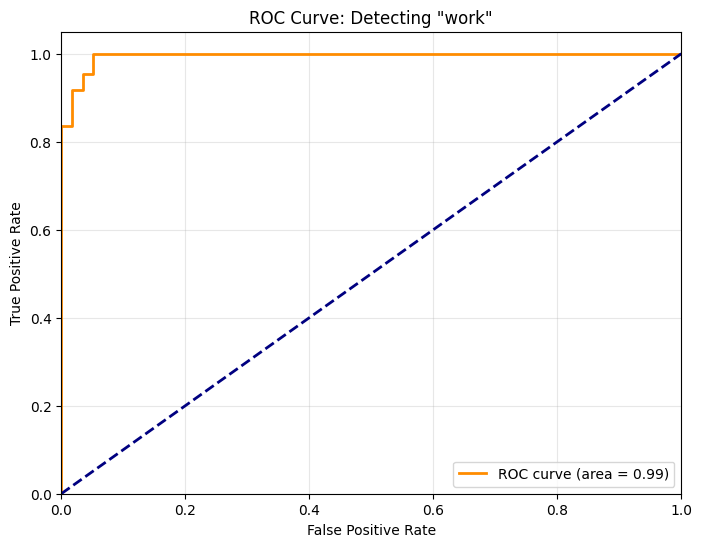

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# 1. Get predictions on the test dataset
# trainer.predict() is a handy helper that runs the loop for us
print("Running inference on test set...")
predictions_output = trainer.predict(test_dataset)

# 2. Extract Logic
raw_logits = torch.tensor(predictions_output.predictions)
true_labels = predictions_output.label_ids

# 3. Apply Softmax to get probabilities
# Dim=1 ensures the rows sum to 1.0 (e.g., 0.1 game, 0.9 work)
probs = torch.nn.functional.softmax(raw_logits, dim=1)

# We need the probabilities of the "Positive" class.
# Let's assume Class 1 is the positive class.
# Check your label map:
print(f"Class Mapping: {id2label}")
positive_class_id = 1
positive_class_name = id2label[str(positive_class_id)]

# Get the column of probabilities corresponding to the positive class
y_scores = probs[:, positive_class_id].numpy()

# 4. Calculate ROC AUC
auc_score = roc_auc_score(true_labels, y_scores)

# 5. Calculate Gini Coefficient
# Gini is mathematically derived from AUC: Gini = 2 * AUC - 1
gini_score = 2 * auc_score - 1

print("-" * 30)
print(f"Target Class for Probabilities: {positive_class_name}")
print(f"ROC AUC Score: {auc_score:.4f}")
print(f"Gini Score:    {gini_score:.4f}")
print("-" * 30)

# 6. Plot the ROC Curve
fpr, tpr, thresholds = roc_curve(true_labels, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # The "random guessing" line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve: Detecting "{positive_class_name}"')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()